# Model Performance Analysis

In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import json
import seaborn as sns

## Load Rollouts from json

In [113]:
rollout_path = "../assets/rollouts/"
rollout_files = glob.glob(os.path.join(rollout_path, "rollout_results_*.json"))

# Load all rollout files
results = {}
for file in rollout_files:
    with open(file, "r") as f:
        # Get the filename without the path and extension e.g "merged_task_1_lora"
        filename = os.path.basename(file)
        filename = filename.split(".")[0]
        filename = "_".join(filename.split("_")[2:])
        # Load the json file
        rollout = json.load(f)
        results[filename] = rollout

print(sorted(results.keys()))


['merged30k_task1_fpft', 'merged30k_task1_lora', 'merged30k_task2_fpft', 'merged30k_task2_lora', 'merged30k_task3_fpft', 'merged30k_task3_lora', 'merged30k_task4_fpft', 'merged30k_task4_lora', 'merged60k_task1_fpft', 'merged60k_task1_lora', 'merged60k_task2_fpft', 'merged60k_task2_lora', 'merged60k_task3_fpft', 'merged60k_task3_lora', 'merged60k_task4_fpft', 'merged60k_task4_lora', 'task1_fpft', 'task1_lora', 'task2_fpft', 'task2_lora', 'task3_fpft', 'task3_lora', 'task4_fpft', 'task4_lora']


## Combine all results into a single DataFrame

----

In [114]:
# Create a DataFrame with all the results (no averaging)
df = pd.DataFrame(columns=["merged", "task", "lora", "success", "task_progress", "grad_steps", "duration"])
for filename, rollout in results.items():
    # Split filename into merged (bool), task (int), lora (bool)
    merged = "merged" in filename
    if merged:
        task = int(filename.split("_")[1][-1])
    else:
        task = int(filename.split("_")[0][-1])
    lora = "lora" in filename
    if "30k" in filename:
        grad_steps = 30_000
    elif "60k" in filename:
        grad_steps = 60_000
    else:
        grad_steps = 20_000

    # Create a temp DataFrame from the rollout
    temp = pd.DataFrame(rollout)
    # Recalculate the score
    for i in range(len(temp)):
        temp.loc[i, "score"] = temp.loc[i, "steps_completed"] / temp.loc[i, "total_steps"]
    # Insert the results into the main DataFrame
    for i in range(len(temp)):
        df.loc[f"{filename}_{i}"] = [merged, task, lora, temp.loc[i, "success"], temp.loc[i, "score"], grad_steps, temp.loc[i, "duration"]]

df

,merged,task,lora,success,task_progress,grad_steps,duration
task4_fpft_0,False,4,False,False,0.666667,20000,14.576691
task4_fpft_1,False,4,False,False,0.666667,20000,21.090429
task4_fpft_2,False,4,False,False,0.666667,20000,36.924832
task4_fpft_3,False,4,False,True,1.000000,20000,22.187122
task4_fpft_4,False,4,False,True,1.000000,20000,20.214878
...,...,...,...,...,...,...,...
merged30k_task2_lora_15,True,2,True,False,0.500000,30000,20.820444
merged30k_task2_lora_16,True,2,True,False,0.500000,30000,19.537650
merged30k_task2_lora_17,True,2,True,False,0.000000,30000,26.210658
merged30k_task2_lora_18,True,2,True,False,0.500000,30000,37.813264


In [115]:
# Create a DataFrame with the averaged results per evaluation run

df_avg = pd.DataFrame(columns=["merged", "task", "lora", "success_rate", "avg_task_progress", "grad_steps", "avg_duration"])
for filename, rollout in results.items():
    # Split filename into merged (bool), task (int), lora (bool)
    merged = "merged" in filename
    if merged:
        task = int(filename.split("_")[1][-1])
    else:
        task = int(filename.split("_")[0][-1])
    lora = "lora" in filename
    if "30k" in filename:
        grad_steps = 30_000
    elif "60k" in filename:
        grad_steps = 60_000
    else:
        grad_steps = 20_000

    # Create a temp DataFrame from the rollout
    temp = pd.DataFrame(rollout)
    # Recalculate the score
    for i in range(len(temp)):
        temp.loc[i, "score"] = temp.loc[i, "steps_completed"] / temp.loc[i, "total_steps"]
    # Calculate the success rate
    success_rate = temp["success"].mean()
    # Calculate the avg task progress
    avg_task_progress = temp["score"].mean()
    avg_duration = temp["duration"].mean()
    
    # Add the results to the main DataFrame
    df_avg.loc[filename] = [merged, task, lora, success_rate, avg_task_progress, grad_steps, avg_duration]

df_avg = df_avg.sort_values(by=["task", "avg_task_progress"], ascending=False)
df_avg

,merged,task,lora,success_rate,avg_task_progress,grad_steps,avg_duration
merged30k_task4_fpft,True,4,False,0.80,0.933333,30000,27.103511
task4_lora,False,4,True,0.80,0.900000,20000,23.301481
task4_fpft,False,4,False,0.70,0.866667,20000,24.787649
merged60k_task4_fpft,True,4,False,0.80,0.866667,60000,28.561584
merged30k_task4_lora,True,4,True,0.55,0.750000,30000,32.522494
merged60k_task4_lora,True,4,True,0.50,0.700000,60000,25.884097
task3_fpft,False,3,False,0.90,0.925000,20000,22.307488
merged60k_task3_fpft,True,3,False,0.90,0.925000,60000,20.925174
merged30k_task3_lora,True,3,True,0.85,0.850000,30000,27.455724
task3_lora,False,3,True,0.85,0.850000,20000,21.408226


*For the merged models, 60k grad_steps is the best for full-fine tuning and 30k grad_steps is the best for LoRA.*

*-> Remove the other entries for now.*

In [116]:
filter = (df["merged"] == False) | ((df["merged"] == True) & (((df["lora"] == False) & (df["grad_steps"] == 60_000)) | ((df["lora"] == True) & (df["grad_steps"] == 30_000))))
df = df[filter].copy()


filter = (df_avg["merged"] == False) | ((df_avg["merged"] == True) & (((df_avg["lora"] == False) & (df_avg["grad_steps"] == 60_000)) | ((df_avg["lora"] == True) & (df_avg["grad_steps"] == 30_000))))
df_avg = df_avg[filter].copy()
df_avg


,merged,task,lora,success_rate,avg_task_progress,grad_steps,avg_duration
task4_lora,False,4,True,0.80,0.900000,20000,23.301481
task4_fpft,False,4,False,0.70,0.866667,20000,24.787649
merged60k_task4_fpft,True,4,False,0.80,0.866667,60000,28.561584
merged30k_task4_lora,True,4,True,0.55,0.750000,30000,32.522494
task3_fpft,False,3,False,0.90,0.925000,20000,22.307488
merged60k_task3_fpft,True,3,False,0.90,0.925000,60000,20.925174
merged30k_task3_lora,True,3,True,0.85,0.850000,30000,27.455724
task3_lora,False,3,True,0.85,0.850000,20000,21.408226
merged60k_task2_fpft,True,2,False,0.25,0.687500,60000,26.827389
task2_fpft,False,2,False,0.35,0.675000,20000,25.961369


## Analyse specific Subsets

### Group by grad_steps

In [117]:
avg_success_rate = df.groupby("grad_steps").success.mean()
print(f"Avg Success Rate for 20k Grad Steps: {avg_success_rate[20000]:.2f}")
print(f"Avg Success Rate for 30k Grad Steps: {avg_success_rate[30000]:.2f}")
print(f"Avg Success Rate for 60k Grad Steps: {avg_success_rate[60000]:.2f}")

avg_task_progress = df.groupby("grad_steps").task_progress.mean()
print()
print(f"Avg Task Progress for 20k Grad Steps: {avg_task_progress[20000]:.2f}")
print(f"Avg Task Progress for 30k Grad Steps: {avg_task_progress[30000]:.2f}")
print(f"Avg Task Progress for 60k Grad Steps: {avg_task_progress[60000]:.2f}")


Avg Success Rate for 20k Grad Steps: 0.61
Avg Success Rate for 30k Grad Steps: 0.53
Avg Success Rate for 60k Grad Steps: 0.65

Avg Task Progress for 20k Grad Steps: 0.82
Avg Task Progress for 30k Grad Steps: 0.73
Avg Task Progress for 60k Grad Steps: 0.84


### Group by merged

In [118]:
avg_success_rate = df.groupby("merged").success.mean()
print(f"Avg Success Rate for Merged Models: {avg_success_rate[True]:.2f}")
print(f"Avg Success Rate for Dedicated Models: {avg_success_rate[False]:.2f}")

avg_task_progress = df.groupby("merged").task_progress.mean()
print()
print(f"Avg Task Progress for Merged Models: {avg_task_progress[True]:.2f}")
print(f"Avg Task Progress for Dedicated Models: {avg_task_progress[False]:.2f}")


Avg Success Rate for Merged Models: 0.59
Avg Success Rate for Dedicated Models: 0.61

Avg Task Progress for Merged Models: 0.79
Avg Task Progress for Dedicated Models: 0.82


### Group by LoRA

In [119]:
avg_success_rate = df.groupby("lora").success.mean()
print(f"Avg Success Rate for LoRA Models: {avg_success_rate[True]:.2f}")
print(f"Avg Success Rate for Non-LoRA Models: {avg_success_rate[False]:.2f}")

avg_task_progress = df.groupby("lora").task_progress.mean()
print()
print(f"Avg Task Progress for LoRA Models: {avg_task_progress[True]:.2f}")
print(f"Avg Task Progress for Non-LoRA Models: {avg_task_progress[False]:.2f}")

Avg Success Rate for LoRA Models: 0.53
Avg Success Rate for Non-LoRA Models: 0.66

Avg Task Progress for LoRA Models: 0.76
Avg Task Progress for Non-LoRA Models: 0.84


### Group by task

In [120]:
avg_success_rate = df.groupby("task").success.mean()
for i in range(1, len(avg_success_rate) + 1):
    print(f"Avg Success Rate for Task {i}: {avg_success_rate[i]:.2f}")

avg_task_progress = df.groupby("task").task_progress.mean()
print()
for i in range(1, len(avg_task_progress) + 1):
    print(f"Avg Task Progress for Task {i}: {avg_task_progress[i]:.2f}")


Avg Success Rate for Task 1: 0.59
Avg Success Rate for Task 2: 0.21
Avg Success Rate for Task 3: 0.88
Avg Success Rate for Task 4: 0.71

Avg Task Progress for Task 1: 0.85
Avg Task Progress for Task 2: 0.62
Avg Task Progress for Task 3: 0.89
Avg Task Progress for Task 4: 0.85


### Group by LoRA and merged

In [121]:
avg_success_rate = df.groupby(["lora", "merged"]).success.mean()
print(avg_success_rate)

avg_task_progress = df.groupby(["lora", "merged"]).task_progress.mean()
print()
print(avg_task_progress)


lora   merged
False  False     0.6750
       True      0.6500
True   False     0.5375
       True      0.5250
Name: success, dtype: float64

lora   merged
False  False     0.845833
       True      0.840625
True   False     0.785417
       True      0.734375
Name: task_progress, dtype: float64


### Group by task and merged

In [122]:
avg_success_rate = df.groupby(["task", "merged"]).success.mean()
print(avg_success_rate)

avg_task_progress = df.groupby(["task", "merged"]).task_progress.mean()
print()
print(avg_task_progress)

task  merged
1     False     0.600
      True      0.575
2     False     0.200
      True      0.225
3     False     0.875
      True      0.875
4     False     0.750
      True      0.675
Name: success, dtype: float64

task  merged
1     False     0.866667
      True      0.841667
2     False     0.625000
      True      0.612500
3     False     0.887500
      True      0.887500
4     False     0.883333
      True      0.808333
Name: task_progress, dtype: float64


## Plots

---

We are trying to answer the following questions:

1. How much better is full fine-tuning than LoRA?
2. How does the difference change over the different tasks?


Question 1

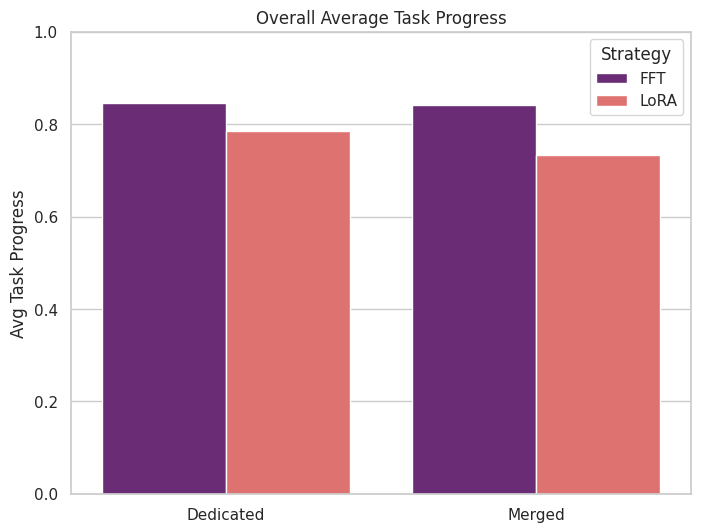

In [123]:
plt.figure(figsize=(8, 6))
# We group by the broad categories for a high-level view
summary_df = df.groupby(['lora', 'merged'])['task_progress'].mean().reset_index()
summary_df['Strategy'] = summary_df.apply(lambda x: 
    f"{'LoRA' if x['lora'] else 'FFT'}", axis=1)
summary_df['Type'] = summary_df.apply(lambda x: 
    f"{'Merged' if x['merged'] else 'Dedicated'}", axis=1)

sns.barplot(data=summary_df, x="Type", y="task_progress", hue="Strategy", palette="magma")
plt.title("Overall Average Task Progress")
plt.xlabel("") # Remove x label
plt.ylabel("Avg Task Progress")
plt.ylim(0, 1.0)
plt.show()

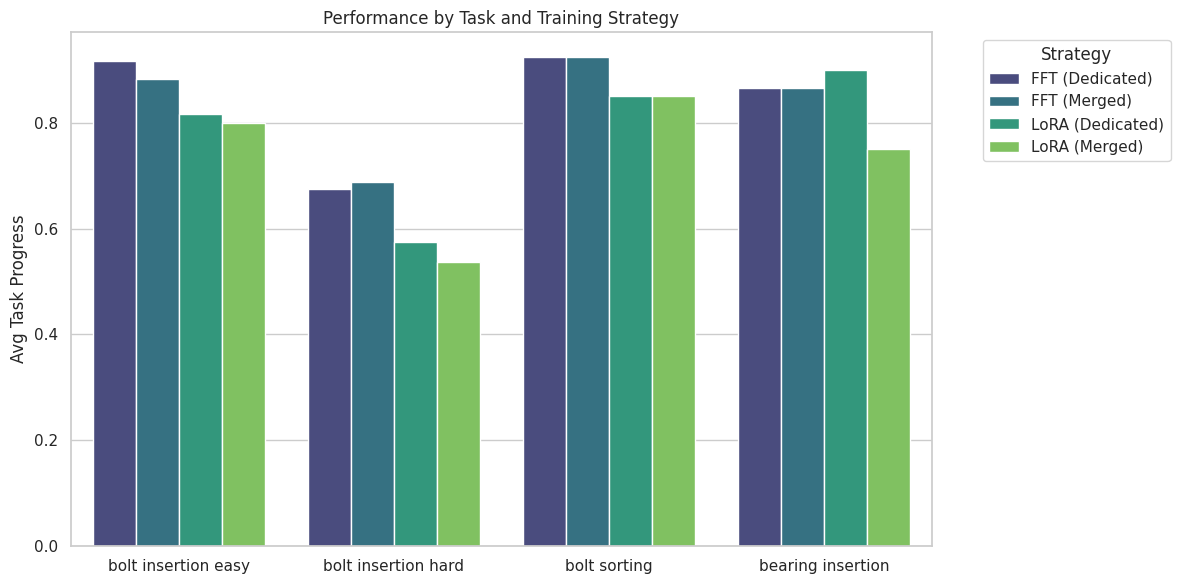

In [158]:
sns.set_theme(style="whitegrid")
plt.rcParams.update({'font.size': 12})

# 1. THE MAIN COMPARISON: Success Rate per Task
# This answers: "Which model is best for which task?"
plt.figure(figsize=(12, 6))
# Create a custom 'Method' column for cleaner legends
df['Method'] = df.apply(lambda x: 
    f"{'LoRA' if x['lora'] else 'FFT'} ({'Merged' if x['merged'] else 'Dedicated'})", axis=1)

task_stings = {
    1: "bolt insertion easy",
    2: "bolt insertion hard",
    3: "bolt sorting",
    4: "bearing insertion"
}

method_order = [
    "FFT (Dedicated)",
    "FFT (Merged)",
    "LoRA (Dedicated)",
    "LoRA (Merged)",
]

# optional: also fix x-axis order
task_order = [
    "bolt insertion easy",
    "bolt insertion hard",
    "bolt sorting",
    "bearing insertion",
]

df['task_str'] = df['task'].apply(lambda x: task_stings[x])

sns.barplot(
    data=df.sort_values(by="task"),
    x="task_str", 
    y="task_progress", 
    hue="Method",
    order=task_order,
    hue_order=method_order,
    palette="viridis",
    errorbar=None,
)
plt.title("Performance by Task and Training Strategy")
plt.ylabel("Avg Task Progress")
plt.xlabel("")
plt.legend(title="Strategy", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Plot Durations

In [125]:
# Build df with successfull episodes only
df_success_only = df.copy().loc[df["success"]]

df_success_only

,merged,task,lora,success,task_progress,grad_steps,duration,Method,task_str
task4_fpft_3,False,4,False,True,1.0,20000,22.187122,FFT (Dedicated),bearing insertion
task4_fpft_4,False,4,False,True,1.0,20000,20.214878,FFT (Dedicated),bearing insertion
task4_fpft_5,False,4,False,True,1.0,20000,26.681844,FFT (Dedicated),bearing insertion
task4_fpft_6,False,4,False,True,1.0,20000,22.647744,FFT (Dedicated),bearing insertion
task4_fpft_9,False,4,False,True,1.0,20000,21.175344,FFT (Dedicated),bearing insertion
...,...,...,...,...,...,...,...,...,...
task4_lora_19,False,4,True,True,1.0,20000,40.925203,LoRA (Dedicated),bearing insertion
merged30k_task2_lora_5,True,2,True,True,1.0,30000,41.916466,LoRA (Merged),bolt insertion hard
merged30k_task2_lora_7,True,2,True,True,1.0,30000,29.589334,LoRA (Merged),bolt insertion hard
merged30k_task2_lora_8,True,2,True,True,1.0,30000,24.187154,LoRA (Merged),bolt insertion hard


    lora  merged   duration Strategy       Type
0  False   False  21.258826      FFT  Dedicated
1  False    True  22.033286      FFT     Merged
2   True   False  19.738034     LoRA  Dedicated
3   True    True  23.864512     LoRA     Merged


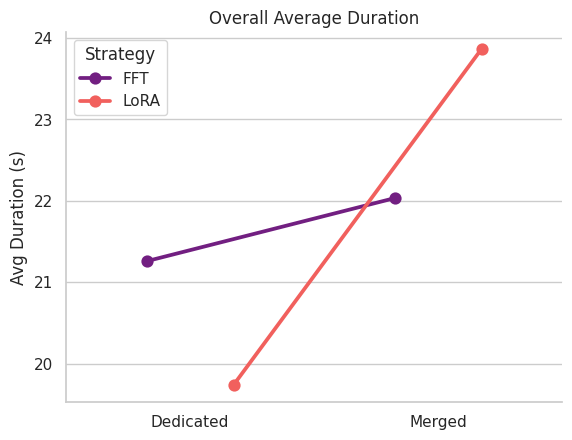

In [ ]:
# We group by the broad categories for a high-level view
summary_df = df_success_only.groupby(['lora', 'merged'])['duration'].mean().reset_index()
summary_df['Strategy'] = summary_df.apply(lambda x: 
    f"{'LoRA' if x['lora'] else 'FFT'}", axis=1)
summary_df['Type'] = summary_df.apply(lambda x: 
    f"{'Merged' if x['merged'] else 'Dedicated'}", axis=1)

print(summary_df)

sns.set_theme(style="whitegrid")

ax = sns.pointplot(
    data=summary_df,
    x="Type",
    y="duration",
    hue="Strategy",
    dodge=0.35,
    errorbar=("ci", 95),  
    capsize=0.15,
    palette="magma",
)
ax.set(title="Overall Average Duration", xlabel="", ylabel="Avg Duration (s)")
sns.despine()
plt.show()

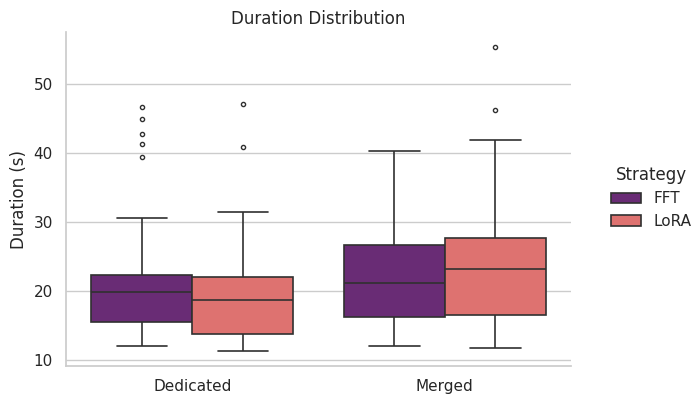

In [157]:
summary_df = df_success_only.copy()
summary_df["Strategy"] = summary_df.apply(lambda x: "LoRA" if x["lora"] else "FFT", axis=1)
summary_df["Type"] = summary_df.apply(lambda x: "Merged" if x["merged"] else "Dedicated", axis=1)

type_order = ["Dedicated", "Merged"]
strategy_order = ["FFT", "LoRA"]

g = sns.catplot(
    data=summary_df,
    x="Type",
    y="duration",
    hue="Strategy",
    kind="box",
    order=type_order,
    hue_order=strategy_order,
    palette="magma",
    height=4.2,
    aspect=1.2,
    linewidth=1.2,
    fliersize=3,
)

g.ax.set(title="Duration Distribution", xlabel="", ylabel="Duration (s)")
g._legend.set_title("Strategy")
g._legend.set_bbox_to_anchor((1.0, 0.6))
g._legend.set_loc("upper left")
g._legend.set_frame_on(False)

sns.despine(ax=g.ax)
plt.tight_layout()
plt.show()

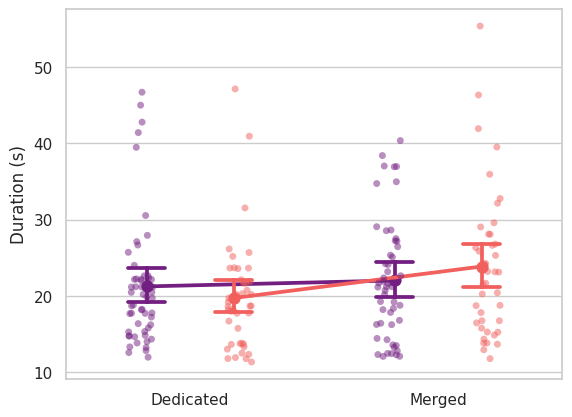

In [128]:
ax = sns.stripplot(data=summary_df, x="Type", y="duration", hue="Strategy", dodge=True, alpha=0.5, palette="magma")
sns.pointplot(data=summary_df, x="Type", y="duration", hue="Strategy", dodge=0.35, errorbar=("ci", 95), capsize=0.15, palette="magma", ax=ax)
ax.legend_.remove()  # optional cleanup; make one legend manually if you want
plt.xlabel("")
plt.ylabel("Duration (s)")
plt.show()